# 情感分析

_人工智能纳米学位课程 | 自然语言处理_

---

随着 Twitter、Facebook 和 Reddit 等在线社交媒体的兴起，以及亚马逊和 Yelp 等网站上的客户评论的飞速增多，我们现在能够获得比以往任何时候都要庞大的文本数据集！我们可以分析这些数据集，了解大部分人群对特定产品和事件等的感受。这种分析称为_情感分析_。在此 notebook 中，你将从头开始构建一个端到端情感分类系统。

## 说明

我们已经为你提供了一些模板代码，你需要实现额外的功能，才能成功完成此 notebook。除了要求的地方之外，你不需要修改所提供代码的其他部分。标题中以 **TODO** 开头的部分表明你需要完成或实现部分代码。我们会在每个部分提供说明，并在以 `# TODO: …` 注释的代码块中提供实现细节。请务必仔细阅读说明！

除了实现代码之外，还需要回答与任务和代码实现相关的问题。以**问题：**开头的部分表示你需要回答问题。请仔细阅读每个问题，并在**答案：**标题下方通过编辑标记单元格，写出答案。

> **注意**：你可以使用 **Shift+Enter** 键盘快捷键执行代码和标记单元格。此外，通常可以通过点击单元格（或双击标记单元格）或在突出显示时按下 **Enter** 键编辑单元格。

## 第 1 步：探索数据！

我们要使用的数据集在自然语言处理研究人员人群当中很受欢迎，通常称为 [IMDb 数据集](http://ai.stanford.edu/~amaas/data/sentiment/)。它由网站 [imdb.com](http://www.imdb.com/) 上的影评组成，每条影评都被标记为 **pos**itive（如果影评人喜欢这部电影），否则被标为 **neg**ative'。

> Maas, Andrew L. 等。[学习情感分析单词向量](http://ai.stanford.edu/~amaas/data/sentiment/)。发布于_第 49 届计算语言学协会年度大会：人类语言技术公报_。计算语言学协会，2011 年。

我们已经为你提供该数据集。你可以通过执行以下 Python 单元格加载该数据集。

In [1]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpusilable_gpus())

ImportError: Traceback (most recent call last):
  File "/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /lib64/libm.so.6: version `GLIBC_2.23' not found (required by /home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so)


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
import os
import glob

def read_imdb_data(data_dir='aclImdb'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


加载数据后，我们快速查看下其中一条正面影评：

In [3]:
print(data['train']['pos'][2])

This movie captures the absurd essence of an overbearing American patriot actor -- one that believes his work (and politics) are as crucial to the American people as the opinions of the President himself. Alan Bates captures this mindset perfectly as Michael Baytes, and I will immortally remember Bates as this character. This is a movie for Canadians and Americans alike. It is a valuable piece of cinema, that which is able to take its audience through the magic of making a film and reveal just how easy it is for the producer and director to lose complete control to the will of the actors and innumerable outside forces. Wonderfully, "Hollywood North" does not suffer from the subject that it portrays: Peter O'Brian directs with precision and complete control, and commands both the serious 'behind-the-scenes' portion of the movie, and the movie-within-the-movie, "Flight to Bogota" with clarity and insight. If you are at all interested in the wit and strength of Canadian cinema, "Hollywood

再看一条负面影评：

In [4]:
print(data['train']['neg'][2])

That's right! Under 9 on average, but maybe under 12s for some others! I was 11 when I originally saw this on video and at such youth I wasn't able to notice the shoddy cartoon-quality or the fact that those classic characters we have all grown to love are Not the same or as good to see. Just about everything is so 2D here! Belle is, I'll agree, not even beautiful but just a plain-looking woman with tinted skin, she wears the same bright blue dress all the way through with not one glamorous dress on, Wardrobe is to say the Least, annoying - my ears may bleed if I had to listen to her everyday! Lumiere, in both the original and the Christmas edition was suave and elegant, but here he is a womanizing, unfunny twit! Cogsworth, despite being the no-nonsense housekeeper he is famous for, is a complete sh-t and the most insufferable character I'd say! He always seems to find shutting that unbearably grating pie-hole of his very difficult in this one and whose clock face should really have be

我们还可以对影评进行 wordcloud 可视化。

In [5]:
# Installing wordcloud
!pip install wordcloud

Looking in indexes: https://edge.dist.yahoo.com:4443/artifactory/api/pypi/pypi/simple, https://edge.dist.yahoo.com:4443/pypimirror/simple
     |████████████████████████████████| 368kB 58.5MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 45.1MB/s eta 0:00:01     |███████████▊                    | 757kB 45.1MB/s eta 0:00:01


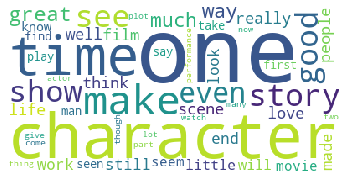

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

尝试将情感改为 `'neg'`，看看能否看出这两个 wordcloud 之间的明显区别。

### TODO：形成训练集和测试集

你已经查看了原始数据，现在请将正面和负面文档结合到一起，获得一个统一的训练集和一个统一的测试集。

In [7]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # TODO: Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # TODO: Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## 第 2 步：预处理

你可能已经在示例影评中注意到了，原始数据包含 HTML。因此需要删除 HTML 标记。我们还需要删除非字母字符、通过将大写字母转换为小写来标准化大写字母、标记化、删除停用词并词干提取每个文档中的剩余单词。

### TODO：将每条影评转换为单词

下个任务是完成执行所有这些步骤的函数 `review_to_words()`。为了方便起见，在下面的 Python 单元格中，我们提供了完成这些预处理步骤可能需要的所有库。确保导入所有这些库（如果不能导入，请从终端通过 pip 安装，并重新运行/导入。）

In [8]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brentweiliu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # TODO: Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    text = BeautifulSoup(review, 'html.parser').get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]

    # Return final list of words
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

完全实现函数 `review_to_words()` 后，我们可以将其应用到训练数据集和测试数据集中的所有影评上。可能需要一段时间，因此构建以下机制：将数据写入缓存文件中，并稍后从缓存文件中获取数据。

In [ ]:
import pickle
from time import time

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting

    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train, words_test = [], []
        i = 0
        start = time()
        for review in data_train:
            words_train.append(review_to_words(review))
            i += 1
            if i == 50:
                end = time()
                print('QPS = %.2f' %(i / (end - start)))
                start = end
                i = 0
                
        i = 0
        for review in data_test:
            words_test.append(review_to_words(review))
            i += 1
            if i % 100 == 0:
                print(i)
            
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
end = 100000
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train[:end], data_test[:end], labels_train[:end], labels_test[:end])

QPS = 28.81
QPS = 37.01
QPS = 36.77
QPS = 35.60
QPS = 34.79
QPS = 28.76
QPS = 33.52
QPS = 32.47
QPS = 36.05
QPS = 30.83
QPS = 35.93
QPS = 34.81
QPS = 36.99
QPS = 32.66
QPS = 33.60
QPS = 36.52
QPS = 37.24
QPS = 29.67
QPS = 41.12
QPS = 28.40
QPS = 29.42
QPS = 36.39
QPS = 29.86
QPS = 34.41
QPS = 36.12
QPS = 28.31
QPS = 32.18
QPS = 37.23
QPS = 39.72
QPS = 32.05
QPS = 38.64
QPS = 38.65
QPS = 28.46
QPS = 36.12
QPS = 31.94
QPS = 30.85
QPS = 33.17
QPS = 36.81
QPS = 35.90
QPS = 28.94
QPS = 33.35
QPS = 32.52
QPS = 37.83
QPS = 33.88
QPS = 35.55
QPS = 27.82
QPS = 36.11
QPS = 38.67
QPS = 34.97
QPS = 32.89
QPS = 36.19
QPS = 29.10
QPS = 35.62
QPS = 32.61
QPS = 34.22
QPS = 30.35
QPS = 33.82
QPS = 30.76
QPS = 32.98
QPS = 43.29
QPS = 34.40
QPS = 30.76
QPS = 33.87
QPS = 33.36
QPS = 32.73
QPS = 26.68
QPS = 27.73
QPS = 33.26
QPS = 29.67


In [15]:
# Take a look at a sample
idx = 1
print("\n--- Raw review ---")
print(data_train[idx])
print("\n--- Preprocessed words ---")
print(words_train[idx])
print("\n--- Label ---")
print(labels_train[idx])

idx = 1
print("\n--- Raw review ---")
print(data_test[idx])
print("\n--- Preprocessed words ---")
print(words_test[idx])
print("\n--- Label ---")
print(labels_test[idx])


--- Raw review ---
I saw this with few expectations and absolutely loved it! Bend it like Beckham is a fairly typical coming-of-age movie about a fairly atypical girl. This is Parminder Nagra ("ER")'s breakout role, playing Jess, a teenager in England who is caught between her traditional Indian family and her love of football (that's soccer to us North Americans). And even though she's actually much older than her character, she plays the role pitch-perfect.<br /><br />This is a movie about friendship - specifically Jess's friendship with Jules (Keira Knightley), her teammate who is also going through family issues, especially with her mom, who wears purple nail polish and little bows on her shoes, and who wants Jules to be more feminine, wear lacy underwear and flirt with boys and is terrified that playing sports means her daughter is a lesbian. Jules and Jess both love playing the game and have issues trying to convince their families to let them go after their dreams. They also, u

## 第 3 步：提取词袋特征

预处理每个文档后，我们可以将每个文档转换为词袋特征表示法。注意，我们需要仅根据训练数据创建此转换，因为根本不能查看测试数据！

这里使用的字典或_词汇表_ $V$（训练集中的文档共享的单词集合）将用于训练我们的监督式学习算法。必须按照相同的方式转换日后的测试数据，以便能够应用学习的模型进行预测。因此，必须存储转换/词汇表。

> **注意**：训练集中的单词集合不一定和测试集完全一样。如果在测试期间遇到之前没见过的单词，该怎么办？遗憾的是，我们需要忽略它，或将其替换为特殊标记 `<UNK>`。

### TODO：计算词袋特征

实现 `extract_BoW_features()` 函数，将其应用到训练数据集和测试数据集，并将结果分别存储在 `features_train` 和 `features_test` NumPy 数组中。选择一个合理的词汇表大小（例如 $|V| = 5000$），并仅保留出现次数为前 $|V|$ 的单词，忽略其余单词。此数字也是词袋矩阵的列数。

> **提示**：你可能会发现 scikit-learn 中的 `CountVectorizer` 很有用。此外确保保存词袋转换以供日后使用。

In [16]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Read features from cache file: bow_features.pkl


In [17]:
# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))
print(len(features_test))
import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))
vocabulary_reverse = {v:k for k, v in vocabulary.items()}
# Sample training data
idx = 1
print("\n--- Raw review ---")
print(data_train[idx])
print("\n--- Preprocessed words ---")
print(words_train[idx])
print("\n--- Bag-of-Words features ---")
print(features_train[idx])
print(type(features_train[idx]))
for i, v in enumerate(features_train[idx]):
    if v != 0:
        print(i, vocabulary_reverse[i], v)
print("\n--- Label ---")
print(labels_train[idx])

# Sample testing data
idx = 1
print("\n--- Raw review ---")
print(data_test[idx])
print("\n--- Preprocessed words ---")
print(words_test[idx])
print("\n--- Bag-of-Words features ---")
print(features_test[idx])
print(type(features_test[idx]))
for i, v in enumerate(features_test[idx]):
    if v != 0:
        print(i, vocabulary_reverse[i], v)
print("\n--- Label ---")
print(labels_test[idx])

Vocabulary: 5000 words
25000
Sample words: ['wilson', 'radio', 'deliber', 'insan', 'flaw', 'jami', 'incorrect', 'subtl']

--- Raw review ---
I saw this with few expectations and absolutely loved it! Bend it like Beckham is a fairly typical coming-of-age movie about a fairly atypical girl. This is Parminder Nagra ("ER")'s breakout role, playing Jess, a teenager in England who is caught between her traditional Indian family and her love of football (that's soccer to us North Americans). And even though she's actually much older than her character, she plays the role pitch-perfect.<br /><br />This is a movie about friendship - specifically Jess's friendship with Jules (Keira Knightley), her teammate who is also going through family issues, especially with her mom, who wears purple nail polish and little bows on her shoes, and who wants Jules to be more feminine, wear lacy underwear and flirt with boys and is terrified that playing sports means her daughter is a lesbian. Jules and Jess bot

我们尝试为某个训练文档可视化词袋特征向量。

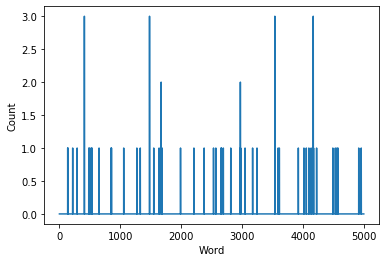

In [18]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()




#### 问题：思考词袋特征表示结果

训练集中的词袋向量平均稀疏程度是多少？换句话说，词袋特征中平均有百分之多少条目为 0？

#### 答案：

...

### 齐波夫定律

[齐波夫定律](https://en.wikipedia.org/wiki/Zipf%27s_law)是以著名的美国语言学家 George Zipf 命名的，它是一条经验定律，表明给定一个大的文档集合，任何单词的频率与其在频率表中的排名成反比。因此最常见的单词频次大约是第二常见单词的两倍，是第三常见单词的三倍，以此类推。在下面的图表中，我们根据训练集中每个单词的排名绘制了单词的频次图表。

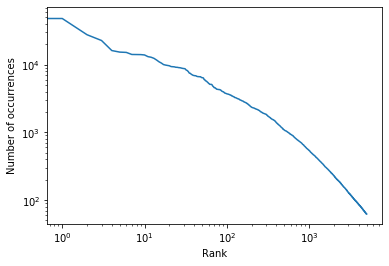

In [19]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

![png](output_23_0.png)


#### 问题：齐波夫定律

最常见单词的总频次是多少？第二常见单词的总频次呢？你的数字遵守齐波夫定律定律吗？如果不遵守，原因是？

#### 答案：

...

### TODO：标准化特征向量

词袋特征很好理解，因为它们是简单的单词计数。但是字数可能差别很大，之后可能会在管道中导致学习算法出错。因此，在继续之前，我们标准化词袋特征向量，使其具有统一的长度。

这样可以确保每个文档的表示结果保留统一的特征成分混合结果，防止字数很多的文档比字数更少的文档影响更大。

In [20]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
print(len(features_train), len(features_test))
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

25000 25000


## 第 4 步：使用词袋特征进行分类

正确转换所有数据后，我们可以将数据馈送到分类器中。要获得基准模型，我们从  scikit-learn 中选择算法（具体而言，是 [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)）训练一个朴素贝叶斯分类器，并通过测试集评估分类器的准确率。

In [21]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


In [22]:
#[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


基于树的算法通常在词袋特征上效果很好，因为数结构可以弥补词袋的高度不连续性和稀疏特性。在下个任务中，你将通过使用  scikit-learn 的梯度提升决策树分类器改善朴素贝叶斯分类器的性能。

### TODO：梯度提升决策树分类器

使用  scikit-learn 中的 [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) 分类词袋数据。此模型有大量参数。我们使用某些默认参数，并为你预设了剩余参数，但是 `n_estimators` 由你来设置。请为该参数设置一个合适的值，用其分类数据，并报告对于朴素贝叶斯算法，你的准确率提高了多少。 

> **提示**：请使用交叉验证、网格搜索或信息准则方法等模型选择技巧得出超参数的最佳值。

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)

    # TODO(optional): Perform hyperparameter tuning / model selection
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.79004


In [24]:
#[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.79004


### TODO：对抗测试

写一条简短的影评来迷惑你的机器学习模型吧！这条影评应该有明显的正面或负面情感，但是模型将分类错误。

> **提示**：你可能需要利用词袋架构最大的薄弱之处！

In [25]:
# TODO: Write a sample review and set its true sentiment
my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# TODO: Then call your classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

--- My review ---
I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end.

--- Preprocessed words ---
['thought', 'would', 'like', 'bore', 'sequel', 'come', 'everyday', 'gone', 'would', 'miss', 'treat', 'bore', 'kept', 'edg', 'seat', 'till', 'end']

True sentiment: pos, predicted sentiment: neg


## 第 5 步：切换工具 - RNN

我们刚刚了解了如何通过传统的机器学习方法解决情感分析任务：词袋 + 非线性分类器。我们现在将切换工具，并使用递归神经网络（具体而言是 LSTM）在 Keras 中执行情感分析。幸运的是，Keras 具有内置的 [IMDb 影评数据集](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification)供我们使用，并且词汇量一样。

In [3]:
!pip install numpy==1.16.1
import numpy as np
print(np.version)

     |████████████████████████████████| 17.3MB 6.7MB/s eta 0:00:01 10.0MB 6.7MB/s eta 0:00:02�██████████████████████▏    | 14.7MB 6.7MB/s eta 0:00:01
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
<module 'numpy.version' from '/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/numpy/version.py'>


In [3]:
from keras.datasets import imdb  # import the built-in imdb dataset in Keras

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data (note the difference in convention compared to scikit-learn)
# old = np.load
# np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)
# from keras.datasets import reuters
# (X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=5000)
# np.load = old
# del(old)


(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

Loaded dataset with 25000 training samples, 25000 test samples


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3']

Using TensorFlow backend.


Loaded dataset with 25000 training samples, 25000 test samples



In [5]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

注意标签是整数（0 表示负面，1 表示正面），影评本身存储为整数序列。它们是预先分配给每个单词的单词 ID。要将它们映射回原始单词，可以使用 `imdb.get_word_index()` 返回的字典。

In [6]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 'successful', 'her', 'anything', 'it', 'of', 'ded

In [7]:
--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 'successful', 'her', 'anything', 'it', 'of', 'dedicated', 'and', 'hard', 'and', 'further', "that's", 'takes', 'as', 'with', 'by', 'br', 'of', 'and', 'in', 'minute', 'and', 'they', 'of', 'westerns', 'watch', 'seemed', 'and', "it's", 'lee', 'if', 'oh', 'this', 'japan', 'film', 'around', 'get', 'an', 'of', 'and', 'always', 'life', 'was', 'between', 'of', 'and', 'with', 'group', 'rate', 'code', "film's", 'was', 'although', 'of', 'arts', 'had', 'death', 'time', 'and', 'of', 'anyway', 'romantic', 'their', 'won', 'in', 'kevin', 'only', 'flying', "it's", 'and', 'only', 'cut', 'show', 'if', 'and', 'is', 'star', 'stay', 'movies', 'both', 'and', 'stay', 'and', 'of', 'music', 'of', 'tell', 'missing', 'they', 'of', 'here', 'really', 'me', 'we', 'value', 'some', 'silent', 'music', 'as', 'had', 'thought', 'and', 'realized', 'she', 'in', 'sorry', 'reasons', 'is', 'and', '10', 'this', 'of', 'and', 'shoots', 'if', 'average', 'remembered', 'in', 'at', 'is', 'over', 'worse', 'film', 'is', 'and', 'it', 'for', 'had', 'absolutely', 'in', 'naive', 'want', 'it', 'for', 'had', 'absolutely', 'in', 'j', 'want', 'it', 'for', 'had', 'back', 'for', 'it', 'absolutely', 'in', 'one', 'want', 'shots', 'has', 'that', 'movie', 'of', 'here', 'write', 'whatsoever', 'it', 'is', 'and', 'set', 'got', 'worse', 'of', 'where', 'and', 'once', 'for', 'of', 'accent', 'after', 'saw', 'she', 'film', 'of', 'rest', 'little', 'and', 'camera', 'if', 'best', 'way', 'elements', 'know', 'of', 'and', 'also', 'an', 'were', 'sense', 'or', 'in', 'realistic', 'actually', 'satan', "he's", 'score', 'br', 'any', 'himself', 'in', 'another', 'type', 'english', 'this', 'is', 'and', 'was', 'tom', 'for', 'dating', 'get', "it's", 'such', 'from', 'fantastic', 'will', 'pace', 'new', 'years', 'of', 'guy', 'game', 'in', 'murders', 'this', 'us', 'hard', 'lives', 'film', 'and', 'fact', 'that', 'out', 'end', 'is', 'getting', 'together', 'br', 'and', 'of', 'seen', 'in', 'of', 'jail', 'for', 'sees', 'utterly', 'it', 'meet', "it's", 'depth', 'is', 'had', 'do', 'you', 'for', 'was', 'rather', 'convince', 'in', 'why', 'last', 'very', 'has', 'i', 'i', 'throughout', 'never', 'keep', 'viewer', 'who', 'of', 'becoming', 'switch', 'and', 'entirely', 'music', 'even', 'interest', 'scene', 'music', 'is', 'far', 'br', 'voice', 'riveting', 'is', 'again', 'something', 'br', 'decent', 'and', 'she', 'this', 'is', 'shoots', 'not', 'director', 'have', 'against', 'people', 'they', 'line', 'cinematography', 'film', 'is', 'couples', 'br', 'and', 'and', 'is', 'and', 'of', 'you', 'it', 'sees', 'hero', "he's", 'if', "can't", 'is', 'time', 'husband', 'silly', 'and', 'result', 'music', 'image', 'sequences', "it's", 'chase', 'music', 'is', 'veteran', 'include', 'and', 'freeman', 'not', 'of', 'and', 'it', 'along', 'are', 'of', 'hearing', 'cutting', 'music', 'his', 'get', 'scene', 'but', 'of', 'fact', 'correct', 'i', 'i', 'means', 'this', 'and', 'this', 'blockbuster', 'as', 'there', 'for', 'disappointed', 'along', 'wrong', 'few', 'has', 'that', 'if', 'his', 'weird', 'way', 'not', 'girl', 'display', 'of', 'love', 'who', 'so', 'friendship', 'in', 'we', 'down', 'it', 'director', 'in', 'situation', 'line', 'has', 'was', 'big', 'why', 'was', 'your', 'supposed', 'last', 'but', 'especially', 'i', 'i', 'of', 'and', 'and', 'of', 'and', 'internet', 'br', 'never', 'give', 'theme', 'rest', 'or', 'really', 'that', 'best', 'and', 'release', 'in', 'for', 'so', 'multi', 'random', 'their', 'even', 'interest', 'is', 'judge', 'once', 'arts', 'like', 'have', 'then', 'own', 'is', 'and', 'has', 'have', 'one', 'is', 'you', 'for', 'off', 'his', 'dutch', 'we', 'they', 'an']
--- Label ---
0


SyntaxError: invalid syntax (<ipython-input-7-18802a98aba2>, line 1)

词袋方法直接将每个单词的数量汇总到一个文档中，而此表示法本质上保留了整个单词序列（没有标点、停用词等）。这对 RNN 的正常运转来说很关键。但是也意味着特征可能长度不一了！

#### 问题：长度不等的影评

训练集中最长的影评有多长（用单词数量计），最短的呢？

#### 答案：

...


### TODO：填充序列

为了将此数据馈送到 RNN 中，所有输入文档必须具有相同的长度。我们将最大影评长度限定为 `max_words`，截断更长的影评并用空值 (0) 填充更短的影评。你可以在 Keras 中使用 [`pad_sequences()`](https://keras.io/preprocessing/sequence/#pad_sequences) 函数轻松实现这一点。暂时，我们将 `max_words` 设为 500。

In [8]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# TODO: Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

### TODO：设计情感分析 RNN 模型

请在下面的代码单元格中构建你的模型架构。我们从 Keras 中导入了一些你可能需要的层级，但是你也可以选择使用任何其他层级/转换。

注意，输入是单词序列（严格来说，是整数单词 ID），最大长度是 `max_words`，输出是二元情感标签（0 或 1）。

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# TODO: Design your model
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
=================================================================
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


SyntaxError: invalid syntax (<ipython-input-10-30848f62f23b>, line 2)

#### 问题：架构和参数

请简要描述下你的神经网络架构。它有多少模型参数需要训练？

#### 答案：

...

### TODO：训练并评估模型

现在你已经准备好训练模型了。在 Keras 环境中，你首先需要_编译_模型，方法是指定训练期间要使用的损失函数和优化器，以及要衡量的任何评估指标。请指定相应的参数，至少包括指标 `'accuracy'`。

In [11]:
# TODO: Compile your model, specifying a loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

编译后，可以开始训练流程了。你需要指定两个重要的训练参数：**批次大小**和**训练周期数**，它们和模型架构一起决定了总的训练时间。

训练可能需要一段时间，喝杯咖啡，或者去徒步一会吧！如果可行的话，考虑使用 GPU，因为在 CPU 上训练一次可能需要好几个小时。

> **提示**：你可以从训练集中拿出一小部分数据，在训练中用作验证集。这样有助于监控训练流程并发现潜在的过拟合问题。你可以使用 `validation_data` 参数将验证集提供给 `model.fit()`，或者直接指定 `validation_split`，让 Keras 为此拿出一部分训练数据（通常是 5-10%）。在每个周期结束时评估验证指标一次。

In [12]:
# TODO: Specify training parameters: batch size and number of epochs
batch_size = 64
num_epochs = 3

# TODO(optional): Reserve/specify some training data for validation (not to be used for training)
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

# TODO: Train your model
model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Instructions for updating:
Use tf.cast instead.
Train on 24936 samples, validate on 64 samples
Epoch 1/3
24936/24936 [==============================] - 198s 8ms/step - loss: 0.4448 - acc: 0.7864 - val_loss: 0.2908 - val_acc: 0.8750
Epoch 2/3
24936/24936 [==============================] - 196s 8ms/step - loss: 0.2806 - acc: 0.8874 - val_loss: 0.3058 - val_acc: 0.8750
Epoch 3/3
24936/24936 [==============================] - 197s 8ms/step - loss: 0.2374 - acc: 0.9093 - val_loss: 0.2794 - val_acc: 0.8750


In [ ]:
Train on 24936 samples, validate on 64 samples
Epoch 1/3
24936/24936 [==============================] - 1342s - loss: 0.4727 - acc: 0.7726 - val_loss: 0.2911 - val_acc: 0.9219
Epoch 2/3
24936/24936 [==============================] - 1360s - loss: 0.3803 - acc: 0.8311 - val_loss: 0.2061 - val_acc: 0.9531
Epoch 3/3
24936/24936 [==============================] - 1140s - loss: 0.2715 - acc: 0.8916 - val_loss: 0.1914 - val_acc: 0.9375


d


<keras.callbacks.History at 0x14027fc18>




In [13]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
import os
model_file = "rnn_model.h5"  # HDF5 file
cache_dir = './'
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

训练模型后，看看它在未见过的测试数据上的表现如何。

In [14]:
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.86648


In [ ]:
Test accuracy: 0.8732


### TODO：对抗测试

写一条简短的影评来迷惑你的机器学习模型吧！这条影评应该有明显的正面或负面情感，但是模型将分类错误。

> **提示**：你可能需要利用词袋架构最大的薄弱之处！

...

## 延伸

你可以通过多种方式继续完善此 notebook。每种方式都有一些挑战性，但是会带来非常有意义的经验。

- 首先是通过尝试不同的架构、层级和参数，提高模型的准确率。在没有花费过长训练时间的情况下，准确率能达到多少？如何防止过拟合？

- 然后，你可能需要将模型部署为移动应用或网络服务。如果要进行此类部署，你需要执行哪些操作？如何接受新的影评、将其转换为适合模型的格式，并进行实际预测？（注意，你在训练过程中使用的环境可能不可用了。）

- 对于此 notebook，我们做出了一个简化：将任务限制为二元分类任务。数据集实际上包含更精细的评分，由每个影评的文件名表示（格式为 `<[id]_[rating].txt>`，其中 `[id]` 是唯一标识符，`[rating]` 的范围是 1-10；注意中性评分 > 4 或 < 7 已被排除）。如何修改 notebook，以对评分执行递归算法？在什么情形下，递归比分类更有用，相反情况呢？

无论你朝着哪个方向发展，都确保与其他学员分享你的结果和学习成果，将结果分享到博客、论坛上，并参与在线竞争项目。这也是吸引潜在雇主的极佳方式！